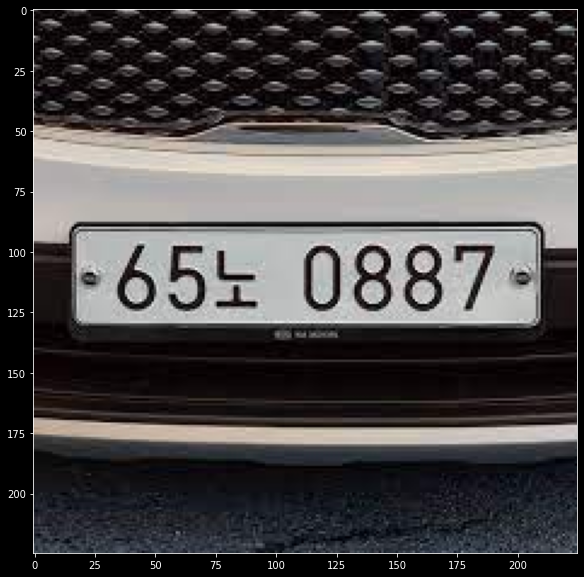

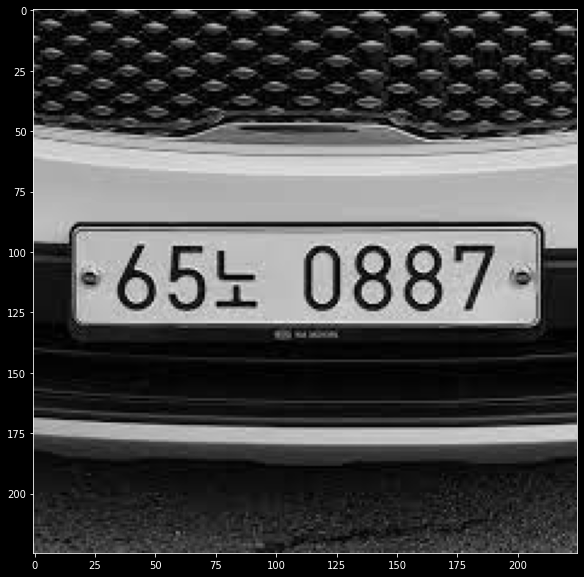

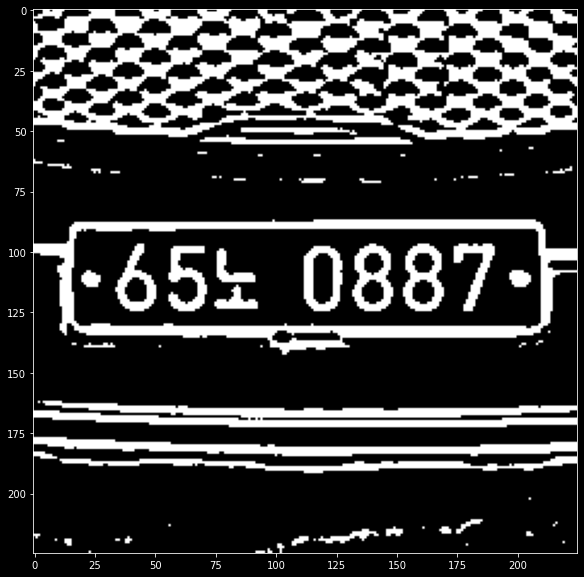

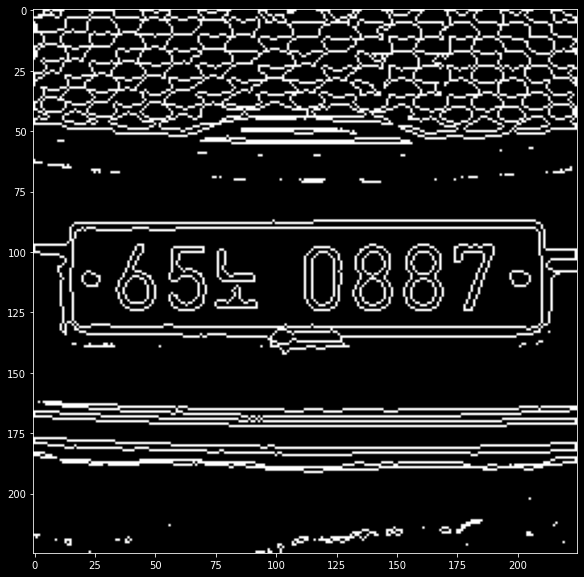

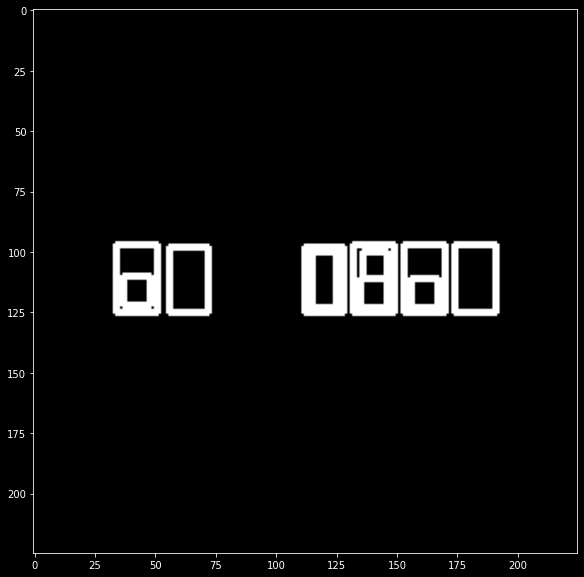

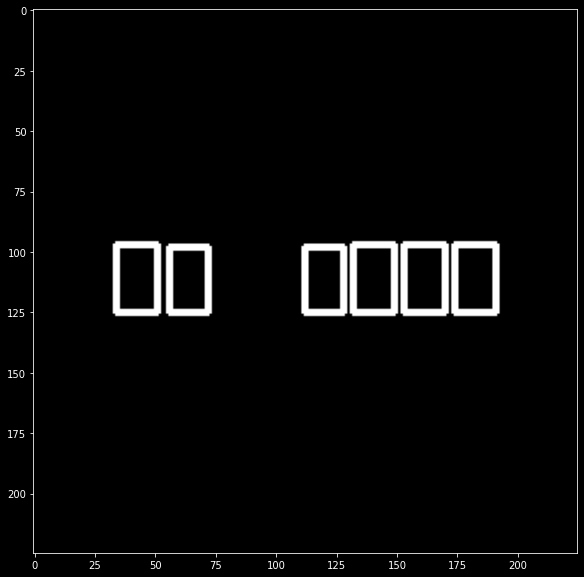

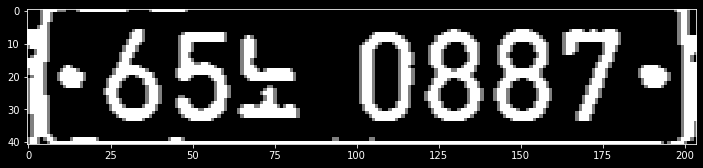

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

img = cv2.imread('car.png')

height, width, channel = img.shape

plt.figure(figsize = (12,10))
plt.imshow(img,cmap='gray') # 원본 이미지

grayimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (12,10))
plt.imshow(grayimg,cmap='gray') # 흑백 이미지

blurredimg = cv2.GaussianBlur(grayimg,ksize=(5,5),sigmaX=0)
blurredimg_thresh = cv2.adaptiveThreshold(blurredimg,maxValue=255.0,adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,thresholdType=cv2.THRESH_BINARY_INV,blockSize=19,C=9)

plt.figure(figsize=(12,10))
plt.imshow(blurredimg_thresh,cmap='gray') # 블러처리하여 노이즈를 제거한 이미지

contours, _ = cv2.findContours(blurredimg_thresh, mode=cv2.RETR_LIST,method=cv2.CHAIN_APPROX_SIMPLE)

tmp = np.zeros((height,width,channel),dtype=np.uint8)

cv2.drawContours(tmp,contours=contours,contourIdx=-1,color=(255,255,255))

plt.figure(figsize=(12,10))
plt.imshow(tmp, cmap = 'gray') # 윤곽선을 검출한 이미지

tmp_res = np.zeros((height,width,channel),dtype=np.uint)

contours_dict = [] # 검출된 폐곡선을 둘러싸는 직사각형의 정보가 담김

for contour in contours:
  x,y,w,h = cv2.boundingRect(contour)
  cv2.rectangle(tmp_res,pt1=(x,y),pt2=(x+w,y+h),color=(255,255,255),thickness=2)

  contours_dict.append({'contour' : contour, 'x':x, 'y':y, 'w':w, 'h':h, 'cx':x+(w/2),'cy':y+(h/2)}) # cx : centerx cy : centery

  MIN_AREA = 80 #contour의 넓이 최소값
  MIN_WIDTH, MIN_HEIGHT = 2,8 # contour의 가로, 세로길이 최소값
  MIN_RATIO, MAX_RATIO = 0.25, 1.0 # 가로, 세로의 비율 최소, 최댓값

  valid_contour = [] # ,조건을 만족하는 유효한 contour

  cnt = 0
  for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
      d['idx'] = cnt
      cnt += 1
      valid_contour.append(d)

tmp_res = np.zeros((height,width,channel),dtype=np.uint8)

for d in valid_contour:
  cv2.rectangle(tmp_res,pt1=(d['x'],d['y']),pt2 = (d['x'] + d['w'], d['y'] + d['h']), color = (255,255,255),thickness = 2)

plt.figure(figsize = (12,10))
plt.imshow(tmp_res,cmap = 'gray') # 검출된 폐곡선들을 둘러싸는 직사각형의 위치 표현

MAX_DIAG_MULTIPLYER = 5 #검출된 contour간의 거리가 contour의 대각선 길이의 "해당변수"배 이내에 있어야한다
MAX_ANGLE_DIFF = 12.0 #검출된 contour간의 위치상 각도가 해당변수 이내여야한다
MAX_AREA_DIFF = 0.5 #검출된 contour간의 넓이 차이(배수)가 해당변수 이내여야한다
MAX_WIDTH_DIFF = 0.8 #검출된 contour간의 가로길이 차이
MAX_HEIGHT_DIFF = 0.2 #검출된 contour간의 세로길이 차이
MIN_N_MATCHED = 3 #위 조건을 모두 만족하는 contour의 갯수가 해당변수 이상이어야한다

def find_chars(contour_list):
  matched_result_idx = []

  for d1 in contour_list:
    matched_contours_idx = []
    for d2 in contour_list:
      if d1['idx'] == d2['idx']:
        continue

      dx = abs(d1['cx']-d2['cx'])
      dy = abs(d1['cy']-d2['cy'])

      diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

      distance = np.linalg.norm(np.array([d1['cx'],d1['cy']]) - np.array([d2['cx'],d2['cy']]))
      if dx == 0:
        angle_diff = 90
      else:
        angle_diff = np.degrees(np.arctan(dy/dx))
      area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
      width_diff = abs(d1['w'] - d2['w']) / d1['w']
      height_diff = abs(d1['h'] - d2['h']) / d1['h']

      if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
        matched_contours_idx.append(d2['idx'])

    matched_contours_idx.append(d1['idx'])

    if len(matched_contours_idx) < MIN_N_MATCHED:
      continue

    matched_result_idx.append(matched_contours_idx)

    unmatched_contour_idx = []
    for d4 in contour_list:
      if d4['idx'] not in matched_contours_idx:
        unmatched_contour_idx.append(d4['idx'])

    unmatched_contour = np.take(valid_contour, unmatched_contour_idx)

    recursive_contour_list = find_chars(unmatched_contour)


    for idx in recursive_contour_list:
      matched_result_idx.append(idx)

    break

  return matched_result_idx

result_idx = find_chars(valid_contour)

matched_result = []
for idx_list in result_idx:
  matched_result.append(np.take(valid_contour,idx_list))

tmp_res = np.zeros((height,width,channel),dtype=np.uint8)

for r in matched_result:
  for d in r:
    cv2.rectangle(tmp_res,pt1 = (d['x'], d['y']), pt2 = (d['x'] + d['w'],d['y']+d['h']), color = (255,255,255),thickness = 2)

plt.figure(figsize = (12,10))
plt.imshow(tmp_res,cmap = 'gray') # 검출된 폐곡선 중에 조건을 만족하는 폐곡선을 둘러싸는 직사각형만 표현

PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
  sorted_chars = sorted(matched_chars, key = lambda x : x['cx']) # x좌표를 기준으로 정렬

  plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
  plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

  plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

  sum_height = 0
  for d in sorted_chars:
    sum_height += d['h']

  plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

  triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
  triangle_hypotenus = np.linalg.norm(np.array([sorted_chars[0]['cx'],sorted_chars[0]['cy']]) - np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']]))

  angle = np.degrees(np.arcsin(triangle_height/triangle_hypotenus))
  rotation_matrix = cv2.getRotationMatrix2D(center = (plate_cx, plate_cy),angle = angle, scale = 1.0)
  rotatedimg = cv2.warpAffine(blurredimg_thresh,M=rotation_matrix,dsize=(width,height))
  croppedimg = cv2.getRectSubPix(rotatedimg,patchSize=(int(plate_width),int(plate_height)),center = (int(plate_cx),int(plate_cy)))

plt.figure(figsize = (12,10))
plt.imshow(croppedimg,cmap = 'gray') # 번호판 부분만 잘라낸 이미지

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,320 kB/s)
debconf: unable to initi